In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.interpolate import interp1d
import sys
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib import cm
import plotly.graph_objects as go
from scipy.special import lpmv

In [ ]:
from math import factorial
def scipy_norm(l,m):
    return (1/(np.sqrt(2*np.pi)))*np.sqrt((2*l+1)/2*factorial(l-m)/factorial(l+m))

In [ ]:
def read_stream(filename):
    f=open(filename,'rb')
    version=np.fromfile(f,np.int32,count=1)[0]#read the version
    time,Ra,Pr,Raxi,Sc,Prmag,Ek,radratio,sigma_ratio=np.fromfile(f,np.float32,count=9)#read the parameters
    print("time from potential file=",time)
    n_r_max,n_r_ic_max,l_max,minc,lm_max=np.fromfile(f,np.int32,count=5)
    m_min,m_max=np.fromfile(f,"{}2i4".format('<'),count=1)[0]
    omega_ic,omega_max=np.fromfile(f,np.float32,count=2)#rotation
    radius=np.fromfile(f,"{}{}f4".format('<',n_r_max),count=1)[0]#radius
    radius=radius[::-1]
    rho=np.fromfile(f,"{}{}f4".format('<',n_r_max),count=1)[0]#background density
    pol=np.fromfile(f,"{}({},{})c8".format('<',n_r_max,lm_max),count=1)[0]#poloidal potential
    pol=pol.T
    tor=np.fromfile(f,"{}({},{})c8".format('<',n_r_max,lm_max),count=1)[0]#toroidal potential
    tor=tor.T
    params=[time,Ra,Pr,Raxi,Sc,Prmag,Ek,radratio,sigma_ratio]
    rad_sph_params=[n_r_max,n_r_ic_max,l_max,minc,lm_max,m_max,m_min]
    omega=[omega_ic,omega_max]
    rad=[radius]
    rho_list=[rho]
    potentials=[pol,tor]
    return version,params,rad_sph_params,omega,rad,rho_list,potentials

In [ ]:
class Legendre:
  def __init__(self,l_max,minc,n_theta_max,m_max,m_min):#initialize function
    self.l_max=l_max#maximum degree of expansion
    self.m_max=m_max#maximum azimuthal mode
    self.minc=minc#azimuthal symmetry
    self.n_theta_max=n_theta_max
    self.n_m_max=m_max//minc+1# Eg: m_max=96 => n_m_max=96//2+1=49
    self.n_phi_max=n_theta_max*2//2
    self.m_min=m_min#included m_min earlier we excluded this

    self.get_index,self.offsets,self.lm_max=self._build_index_map()#called all of them itself here as class objects rather than in main routine
    self.idx,self.lm2l,self.lm2m=self._LMmapping()
    self.LM_list=self._getLM(self.idx)
    self.lStart,self.lStop,self.lmOdd=self._getblocks()

    #declare arrays
    self.Plm=np.zeros((self.lm_max,self.n_theta_max//2))    #P_l^m(cos(theta))
    self.wPlm=np.zeros_like(self.Plm)   #weighted P_l^m
    self.wdPlm=np.zeros_like(self.Plm)  #weighted derivative
    self.dPlm=np.zeros_like(self.Plm)   #derivative wrt theta
    self.dPhi=np.zeros_like(self.Plm)   #derivative wrt phi
    self.sinTh=np.zeros(n_theta_max)  #sin(theta) values
    self.gauss=np.zeros(n_theta_max)  #gauss-legendre polynomial

    #theta and weights
    self.theta_ord,self.gauss=self._gauleg(self.n_theta_max)

    dpi=np.pi

    for ntheta in range(self.n_theta_max//2):
      colat=self.theta_ord[ntheta]
      plma,dtheta_plma=self._plm_theta(colat)
      lm=0
      for m in range(0,self.m_max+1,self.minc):
        for l in range(m,self.l_max+1):
          self.Plm[lm,ntheta]=((-1.0)**m)*plma[lm]
          self.dPlm[lm,ntheta]=((-1.0)**m)*dtheta_plma[lm]/(np.sin(colat))
          self.dPhi[lm,ntheta]=m/(np.sin(colat))
          self.wPlm[lm,ntheta]=2.0*dpi*self.gauss[ntheta]*self.Plm[lm,ntheta]
          self.wdPlm[lm,ntheta]=2.0*dpi*self.gauss[ntheta]*self.dPlm[lm,ntheta]
          lm+=1


  def _build_index_map(self):#previously it took m_max and minc as arguments
    m_values=list(range(0,self.m_max+1,self.minc))
    offsets={}
    idx=0
    for m in m_values:
      offsets[m]=idx
      idx+=(l_max-m+1)
    total=idx
    def get_index(m,l):
      return offsets[m]+(l-m)
    return get_index,offsets,total

  def _LMmapping(self):
    idx=np.zeros((self.l_max+1,self.m_max+1),np.int32)
    lm2l=np.zeros(self.lm_max,np.int16)
    lm2m=np.zeros(self.lm_max,np.int16)
    k=0
    for m in range(self.m_min,self.m_max+1,self.minc):#earlier the last slot was 0 as loop was only upto m_max
      for l in range(m,self.l_max+1):
        idx[l,m]=k
        lm2l[k]=l
        lm2m[k]=m
        k+=1
    return idx,lm2l,lm2m

  def _getLM(self,idx):
    LM_list=[]
    for m in range(self.m_min,self.m_max+1,self.minc):
      for l in range(m,self.l_max+1):
        LM_list.append(idx[l,m])
    LM_list=np.array(LM_list)
    return LM_list# the last entry is lm_max-1 as python idexing starts from 0

  def _getblocks(self):#start and end index of each m block, the first block m=0 has all l and last will have only 1
    lStart=np.zeros(self.n_m_max,dtype=int)
    lStop=np.zeros(self.n_m_max,dtype=int)
    lmOdd=np.zeros(self.n_m_max,dtype=int)

    lStart[0]=0#lStart[0]=1
    lStop[0]=self.l_max#lStop[0]=l_max+1
    lmOdd[0]=(self.l_max%2==0)

    for mc in range(1,self.n_m_max):
      m=mc*self.minc
      lStart[mc]=lStop[mc-1]+1
      lStop[mc]=lStart[mc]+(self.l_max-m)
      lmOdd[mc]=((lStop[mc]-lStart[mc])%2==0)

    return lStart,lStop,lmOdd

  def _gauleg(self,n_theta_max):
    theta_ord=np.zeros(n_theta_max)
    gauss=np.zeros(n_theta_max)

    dpi=np.pi
    M=(n_theta_max+1)//2
    XXM=0.0
    XXL=1.0
    eps=3e-14

    for i in range(1,M+1):
      zz=np.cos(dpi*((i-0.25)/(n_theta_max+0.5)))
      zz1=0.0

      while abs(zz-zz1)>eps:
        p1=1.0
        p2=0.0
        for j in range(1,n_theta_max+1):
          p3=p2
          p2=p1
          p1=((2*j-1)*zz*p2-(j-1)*p3)/j
        pp=n_theta_max*(zz*p1-p2)/(zz*zz-1.0)
        zz1=zz
        zz=zz1-p1/pp

      theta_ord[i-1]=np.arccos(XXM+XXL*zz)
      theta_ord[n_theta_max-i]=np.arccos(XXM-XXL*zz)
      w=2.0*XXL/((1.0-zz**2)*pp**2)
      gauss[i-1]=w
      gauss[n_theta_max-i]=w

    return theta_ord,gauss

  def _plm_theta(self,theta):
    m_values=list(range(self.m_min,self.m_max+1,self.minc))#produces m_values and ndim_req produces
    ndim_req=sum((self.l_max-m+1) for m in m_values)#same output as previous LM routines

    plma=np.zeros(ndim_req,dtype=np.float64)
    dtheta_plma=np.zeros(ndim_req,dtype=np.float64)

    dnorm=1.0/np.sqrt(16.0*np.atan(1.0))
    pos=-1

    for m in m_values:
      fac=1.0
      for j in range(3,2*m+2,2):#this section computes P^m_m for recurrence to buid higher P^m_m+1,P^m_m+2....P^m_lmax
        fac*=float(j)/float(j-1)
      plm0=np.sqrt(fac)
      s=np.sin(theta)
      if abs(s)>0.0:
        plm0=plm0*((-s)**m)
      elif m!=0:
        plm0=0.0

      l=m
      pos+=1
      plma[pos]=dnorm*plm0
      plm1=0.0

      for l in range(m+1,self.l_max+1):
        plm2=plm1#for l=m second term becomes zeros and hence recurrence remains consistent
        plm1=plm0
        num1=(2*l-1)*(2*l+1)
        den1=(l-m)*(l+m)
        term1=np.cos(theta)*np.sqrt(float(num1)/float(den1))*plm1
        num2=(2*l+1)*(l+m-1)*(l-m-1)
        den2=(2*l-3)*(l-m)*(l+m)
        term2=np.sqrt(float(num2)/float(den2))*plm2 if (den2!=0) else 0
        plm0=term1-term2
        pos+=1
        plma[pos]=dnorm*plm0

      l=self.l_max+1
      plm2=plm1
      plm1=plm0
      num1=(2*l-1)*(2*l+1)
      den1=(l-m)*(l+m)
      term1=np.cos(theta)*np.sqrt(float(num1)/float(den1))*plm1
      num2=(2*l+1)*(l+m-1)*(l-m-1)
      den2=(2*l-3)*(l-m)*(l+m)
      term2=np.sqrt(float(num2)/float(den2))*plm2
      plm0=term1-term2
      dtheta_plma[pos]=dnorm*plm0

    pos=-1
    for m in m_values:
      l=m
      pos+=1
      if m<self.l_max:
        dtheta_plma[pos]=(l/np.sqrt(float(2*l+3)))*plma[pos+1]
      else:
        dtheta_plma[pos]=(l/np.sqrt(float(2*l+3)))*plma[pos]

      for l in range(m+1,self.l_max):
        pos+=1
        termA=l*np.sqrt(float((l+m+1)*(l-m+1))/float((2*l+1)*(2*l+3)))*plma[pos+1]
        termB=(l+1)*np.sqrt(float((l+m)*(l-m))/float((2*l-1)*(2*l+1)))*plma[pos-1]
        dtheta_plma[pos]=termA-termB

      if m<self.l_max:
        l=self.l_max
        pos+=1
        termA=l*np.sqrt(float((l+m+1)*(l-m+1))/float((2*l+1)*(2*l+3)))*dtheta_plma[pos]
        termB=(l+1)*np.sqrt(float((l+m)*(l-m))/float((2*l-1)*(2*l+1)))*plma[pos-1]
        dtheta_plma[pos]=termA-termB

    return plma,dtheta_plma



#testing the LM indexing

In [ ]:
version,params,rad_sph_params,omega,rad,rho_list,potentials=read_stream('V_lmr_1000.test_BIS')
l_max,minc,m_max,m_min=rad_sph_params[2],rad_sph_params[3],rad_sph_params[5],rad_sph_params[6]
#print("l_max=",l_max,"\n minc=",minc,"\n m_max=",m_max,"\n m_min=",m_min)
leg=Legendre(l_max,minc,144,m_max,m_min)
get_index,offsets,total=leg._build_index_map()
print("offsets=",offsets,"\n total=",total,"\n get_index=",get_index(42,48))
idx,lm2l,lm2m=leg._LMmapping()
print("lm2l=",lm2l,"\t shape=",lm2l.shape,"\n lm2m=",lm2m,"\t shape=",lm2m.shape)
LM_list=leg._getLM(idx)
print("LM list=",LM_list,"\t shape=",LM_list.shape)
lStart,lStop,lmOdd=leg._getblocks()
print("lStart =",lStart,"\t shape=",lStart.shape,"\n lStop=",lStop,"\t shape=",lStop.shape,"\n lmOdd=",lmOdd,"\t shape=",lmOdd.shape)

time from potential file= 0.9499
offsets= {0: 0, 2: np.int32(97), 4: np.int32(192), 6: np.int32(285), 8: np.int32(376), 10: np.int32(465), 12: np.int32(552), 14: np.int32(637), 16: np.int32(720), 18: np.int32(801), 20: np.int32(880), 22: np.int32(957), 24: np.int32(1032), 26: np.int32(1105), 28: np.int32(1176), 30: np.int32(1245), 32: np.int32(1312), 34: np.int32(1377), 36: np.int32(1440), 38: np.int32(1501), 40: np.int32(1560), 42: np.int32(1617), 44: np.int32(1672), 46: np.int32(1725), 48: np.int32(1776), 50: np.int32(1825), 52: np.int32(1872), 54: np.int32(1917), 56: np.int32(1960), 58: np.int32(2001), 60: np.int32(2040), 62: np.int32(2077), 64: np.int32(2112), 66: np.int32(2145), 68: np.int32(2176), 70: np.int32(2205), 72: np.int32(2232), 74: np.int32(2257), 76: np.int32(2280), 78: np.int32(2301), 80: np.int32(2320), 82: np.int32(2337), 84: np.int32(2352), 86: np.int32(2365), 88: np.int32(2376), 90: np.int32(2385), 92: np.int32(2392), 94: np.int32(2397), 96: np.int32(2400)} 
 total

In [ ]:
print("offsets=",leg.offsets,"\n total=",leg.lm_max,"\n get_index=",leg.get_index(42,48))
print("lm2l=",leg.lm2l,"\t shape=",leg.lm2l.shape,"\n lm2m=",leg.lm2m,"\t shape=",leg.lm2m.shape)
print("LM list=",leg.LM_list,"\t shape=",leg.LM_list.shape)
print("lStart =",leg.lStart,"\t shape=",leg.lStart.shape,"\n lStop=",leg.lStop,"\t shape=",leg.lStop.shape,"\n lmOdd=",leg.lmOdd,"\t shape=",leg.lmOdd.shape)

offsets= {0: 0, 2: np.int32(97), 4: np.int32(192), 6: np.int32(285), 8: np.int32(376), 10: np.int32(465), 12: np.int32(552), 14: np.int32(637), 16: np.int32(720), 18: np.int32(801), 20: np.int32(880), 22: np.int32(957), 24: np.int32(1032), 26: np.int32(1105), 28: np.int32(1176), 30: np.int32(1245), 32: np.int32(1312), 34: np.int32(1377), 36: np.int32(1440), 38: np.int32(1501), 40: np.int32(1560), 42: np.int32(1617), 44: np.int32(1672), 46: np.int32(1725), 48: np.int32(1776), 50: np.int32(1825), 52: np.int32(1872), 54: np.int32(1917), 56: np.int32(1960), 58: np.int32(2001), 60: np.int32(2040), 62: np.int32(2077), 64: np.int32(2112), 66: np.int32(2145), 68: np.int32(2176), 70: np.int32(2205), 72: np.int32(2232), 74: np.int32(2257), 76: np.int32(2280), 78: np.int32(2301), 80: np.int32(2320), 82: np.int32(2337), 84: np.int32(2352), 86: np.int32(2365), 88: np.int32(2376), 90: np.int32(2385), 92: np.int32(2392), 94: np.int32(2397), 96: np.int32(2400)} 
 total= 2401 
 get_index= 1623
lm2l= [ 

#testing Legendre relations

In [ ]:
#m_values,ndim_req=leg._plm_theta(0.01)
#print("m values =",m_values,"\t shape =",len(m_values),"\n ndim_req =",ndim_req)
l_max,m_max,minc,m_min=6,5,1,0
n_theta=250
leg=Legendre(l_max,minc,144,m_max,m_min)
#print(leg.theta_ord)
x=np.cos(leg.theta_ord)
w=leg.gauss
for k in [0,2,4,6]:
  exact=2.0/(k+1) if k%2==0 else 0.0
  approx=np.sum(w*x**k)
  print(f"k={k}: exact={exact:.6e}, approx={approx:.6e}, error={abs(exact-approx):.2e}")

thet=leg.theta_ord[0]#take theta=0
plma,dtheta_pma=leg._plm_theta(thet)

print("Comparison at theta=%.3f (radians)"%thet)
pos=-1
for m in range(m_max+1):
  for l in range(m,l_max+1):
    pos+=1
    norms=scipy_norm(l,m)
    x=np.cos(thet)
    scipy_val=norms*lpmv(m,l,x)
    our_val=plma[pos]
    print(f"(l={l}, m={m}): scipy={scipy_val:.6e}, ours={our_val:.6e}, ratio={our_val/(scipy_val+1e-30):.6e}")

k=0: exact=2.000000e+00, approx=2.000000e+00, error=8.26e-14
k=2: exact=6.666667e-01, approx=6.666667e-01, error=8.23e-14
k=4: exact=4.000000e-01, approx=4.000000e-01, error=8.19e-14
k=6: exact=2.857143e-01, approx=2.857143e-01, error=8.16e-14
Comparison at theta=0.017 (radians)
(l=0, m=0): scipy=2.820948e-01, ours=2.820948e-01, ratio=1.000000e+00
(l=1, m=0): scipy=4.885348e-01, ours=4.885348e-01, ratio=1.000000e+00
(l=2, m=0): scipy=6.305211e-01, ours=6.305211e-01, ratio=1.000000e+00
(l=3, m=0): scipy=7.457326e-01, ours=7.457326e-01, ratio=1.000000e+00
(l=4, m=0): scipy=8.451128e-01, ours=8.451128e-01, ratio=1.000000e+00
(l=5, m=0): scipy=9.336601e-01, ours=9.336601e-01, ratio=1.000000e+00
(l=6, m=0): scipy=1.014151e+00, ours=1.014151e+00, ratio=1.000000e+00
(l=1, m=1): scipy=-5.749572e-03, ours=-5.749572e-03, ratio=1.000000e+00
(l=2, m=1): scipy=-1.285465e-02, ours=-1.285465e-02, ratio=1.000000e+00
(l=3, m=1): scipy=-2.150548e-02, ours=-2.150548e-02, ratio=1.000000e+00
(l=4, m=1): sc

(72,)


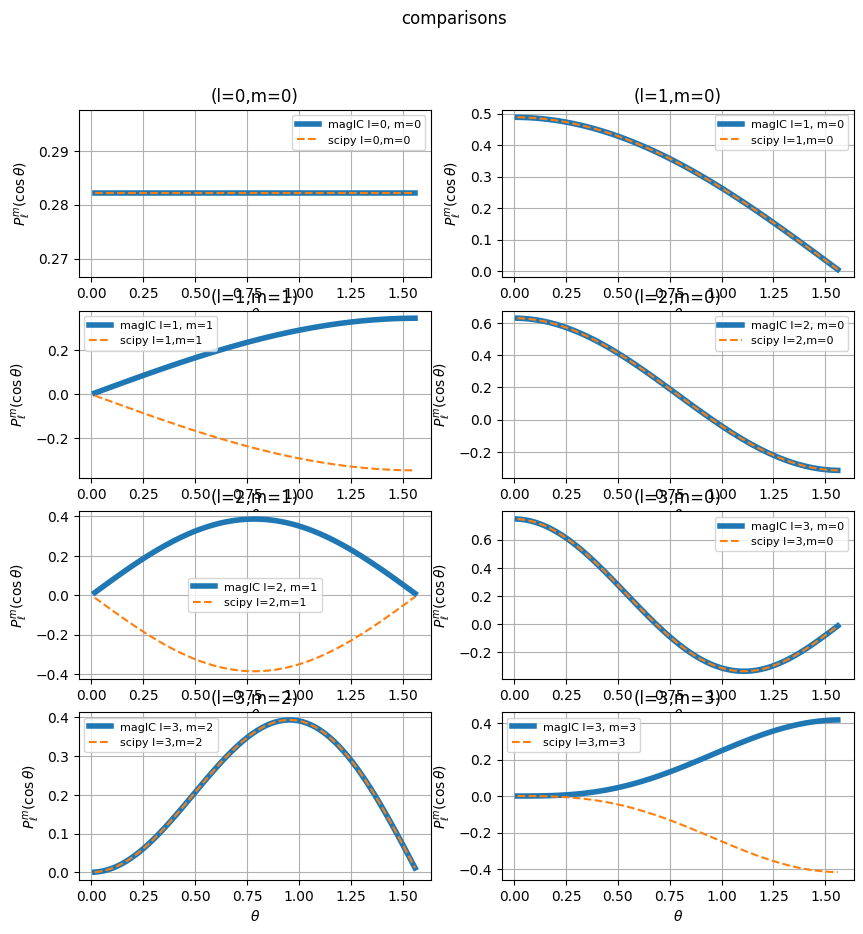

In [ ]:
pairs=[(0,0),(1,0),(1,1),(2,0),(2,1),(3,0),(3,2),(3,3)]
print(leg.theta_ord[:leg.n_theta_max//2].shape)
half_sph=leg.theta_ord[:leg.n_theta_max//2]
x=np.cos(half_sph)
n_plots=len(pairs)

fig,axes=plt.subplots(nrows=len(pairs)//2+len(pairs)%2,ncols=2,figsize=(10,10))
axes=axes.flatten()
for i,(l,m) in enumerate(pairs):
  ax=axes[i]
  idx=leg.get_index(m,l)
  our_val=leg.Plm[idx,:]
  norms=scipy_norm(l,m)
  scipy_val=norms*lpmv(m,l,x)

  ax.plot(half_sph,our_val,linewidth=4.0,label=f"magIC l={l}, m={m}")
  ax.plot(half_sph,scipy_val,'--',label=f"scipy l={l},m={m}")
  ax.set_xlabel(r"$\theta$")
  ax.set_ylabel(r"$P_\ell^m(\cos\theta)$")
  ax.grid(True)
  ax.legend(fontsize=8)
  ax.set_title(f"(l={l},m={m})")

plt.suptitle(f"comparisons")
plt.show()